In [1]:
import os
import json
import requests
import csv
import numpy as np
import pandas as pd
import geopandas as gpd
from zipfile import ZipFile
from datetime import date, timedelta, datetime
from arcgis.gis import GIS
from arcgis.features import FeatureLayerCollection

In [2]:
print(str(datetime.now()) + " Running 1_COVID_Daily_Cases_Process")
yearDate = date.today().strftime('%m%d%y')
print("today: "+yearDate)
yesterday = date.today() - timedelta(days=1)
yearDate_yesterday = yesterday.strftime('%m%d%y')
print("yesterday: "+yearDate_yesterday)

2020-11-16 17:28:28.548287 Running 1_COVID_Daily_Cases_Process
today: 111620
yesterday: 111520


### Download data

In [3]:
gis = GIS()
daily_covid_county_service_id = 'a7887f1940b34bf5a02c6f7f27a5cb2c'
covid_cases = gis.content.get(daily_covid_county_service_id)
covid_cases

<Item title:"Florida COVID19 Cases by County" type:Feature Layer Collection owner:Epidemiology.GIS>

In [4]:
query = covid_cases.layers[0].query(where="1=1")
df_covid_cases = query.sdf
df_covid_cases.head()

,OBJECTID,OBJECTID_12_13,DEPCODE,COUNTY,COUNTYNAME,County_1,State,PUIsTotal,Age_0_4,Age_5_14,...,MonNow,Shape__Area,Shape__Length,GlobalID,NewPos,NewNeg,NewTested,NewPercPos,MedianAge,SHAPE
0,1,1,21,041,GILCHRIST,Gilchrist,FL,1502,39,87,...,767,9.204908e+08,148547.348006,cb6285a2-da2e-4583-aad5-1221776836ae,4,17,21,0.190476,41,"{""rings"": [[[529493.625602742, 647744.81243718..."
1,2,2,54,107,PUTNAM,Putnam,FL,6297,174,567,...,1614,2.142439e+09,232574.925675,ce511c5d-2638-44a3-b2f8-b13847543637,3,73,76,0.039474,40,"{""rings"": [[[633424.87518893, 650359.936015058..."
2,3,3,62,123,TAYLOR,Taylor,FL,2826,66,168,...,1564,2.685253e+09,267348.178950,541bd5a3-4453-499a-9896-f0edc5353d0b,5,14,19,0.263158,40,"{""rings"": [[[425905.96838189, 699605.625594474..."
3,4,4,46,091,OKALOOSA,Okaloosa,FL,16173,339,1179,...,10723,2.369223e+09,330553.160278,eb5d2450-a892-40fd-9ba4-9821a7438525,59,329,388,0.152062,40,"{""rings"": [[[170978.169305377, 740209.62491612..."
4,5,5,7,013,CALHOUN,Calhoun,FL,1573,33,120,...,1135,1.487627e+09,192207.890331,3b55aa95-5170-4caf-82a3-e99ad7459349,5,9,14,0.357143,44,"{""rings"": [[[310646.592981238, 733517.62524545..."


In [5]:
df_covid_cases_drop = df_covid_cases.drop(columns=['SHAPE'])
df_Case = df_covid_cases_drop.sort_values(by=['DEPCODE'])
df_Case.head()

,OBJECTID,OBJECTID_12_13,DEPCODE,COUNTY,COUNTYNAME,County_1,State,PUIsTotal,Age_0_4,Age_5_14,...,EverMon,MonNow,Shape__Area,Shape__Length,GlobalID,NewPos,NewNeg,NewTested,NewPercPos,MedianAge
65,66,66,1,001,ALACHUA,Alachua,FL,26717,417,692,...,1770,1747,2.510756e+09,272135.471452,9eddb8fb-00dd-45f1-a09d-8e689049e28a,61,651,712,0.085674,24
16,17,17,2,003,BAKER,Baker,FL,3169,71,154,...,2235,2234,1.520246e+09,183737.354704,393e3bc9-079e-4ad6-9162-d77ee72feb59,3,64,67,0.044776,41
14,15,15,3,005,BAY,Bay,FL,11231,139,341,...,2047,2040,1.930771e+09,558412.990826,a66f3b06-8ee0-4dec-843e-f41d712aad2f,53,209,262,0.202290,42
39,40,40,4,007,BRADFORD,Bradford,FL,2980,70,162,...,1902,1871,7.767446e+08,167178.838253,588f1d06-056b-4af5-a2e7-a5366c833ba5,1,20,21,0.047619,46
41,42,42,5,009,BREVARD,Brevard,FL,32629,423,1008,...,3251,3193,2.687644e+09,793218.333609,943db4a8-472c-444e-b81a-0e7cf9758ca2,49,921,970,0.050515,44


In [6]:
covid_data_updated = covid_cases.layers[0].properties.editingInfo.lastEditDate
covid_update_time = datetime.fromtimestamp(covid_data_updated/1000).strftime('%m/%d/%y %H:%M ET')
print("COVID Cases by County data is updated at {}".format(covid_update_time))

COVID Cases by County data is updated at 11/16/20 15:31 ET


In [7]:
# add covid data update time to excel file - df_Case "Florida_COVID19_Cases_by_County" sheet
df_Case['UpdateTime'] = covid_update_time
df_Case

,OBJECTID,OBJECTID_12_13,DEPCODE,COUNTY,COUNTYNAME,County_1,State,PUIsTotal,Age_0_4,Age_5_14,...,MonNow,Shape__Area,Shape__Length,GlobalID,NewPos,NewNeg,NewTested,NewPercPos,MedianAge,UpdateTime
65,66,66,1,001,ALACHUA,Alachua,FL,26717,417,692,...,1747,2.510756e+09,272135.471452,9eddb8fb-00dd-45f1-a09d-8e689049e28a,61,651,712,0.085674,24,11/16/20 15:31 ET
16,17,17,2,003,BAKER,Baker,FL,3169,71,154,...,2234,1.520246e+09,183737.354704,393e3bc9-079e-4ad6-9162-d77ee72feb59,3,64,67,0.044776,41,11/16/20 15:31 ET
14,15,15,3,005,BAY,Bay,FL,11231,139,341,...,2040,1.930771e+09,558412.990826,a66f3b06-8ee0-4dec-843e-f41d712aad2f,53,209,262,0.202290,42,11/16/20 15:31 ET
39,40,40,4,007,BRADFORD,Bradford,FL,2980,70,162,...,1871,7.767446e+08,167178.838253,588f1d06-056b-4af5-a2e7-a5366c833ba5,1,20,21,0.047619,46,11/16/20 15:31 ET
41,42,42,5,009,BREVARD,Brevard,FL,32629,423,1008,...,3193,2.687644e+09,793218.333609,943db4a8-472c-444e-b81a-0e7cf9758ca2,49,921,970,0.050515,44,11/16/20 15:31 ET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40,41,41,65,129,WAKULLA,Wakulla,FL,3414,77,323,...,2160,1.579534e+09,279225.038340,72742cee-2b13-49f0-be2b-615f9835dd19,2,35,37,0.054054,41,11/16/20 15:31 ET
50,51,51,66,131,WALTON,Walton,FL,5301,100,229,...,1438,2.708102e+09,370154.781285,31ca379b-fb64-4c77-9456-056bcf505a65,20,96,116,0.172414,41,11/16/20 15:31 ET
52,53,53,67,133,WASHINGTON,Washington,FL,2446,51,126,...,1315,1.594397e+09,243766.072260,ed919630-6db9-4e1b-b6b4-eafa4d161468,20,17,37,0.540541,43,11/16/20 15:31 ET
68,70,69,998,998,A State,State,FL,1813550,35010,79492,...,399147,NaN,NaN,e2d719ef-85bc-44e7-84ed-af74ad1ec87d,4531,52691,57222,6.791573,40,11/16/20 15:31 ET


In [8]:
covid_by_population_id = '09e0d01d8e8e46b6ae678c256d918178'
covid_popu = gis.content.get(covid_by_population_id)
covid_popu

<Item title:"Case Maps for COVID19" type:Feature Layer Collection owner:Epidemiology.GIS>

In [9]:
query_popu = covid_popu.layers[0].query(where="1=1")
df_cases_popu = query_popu.sdf
df_cases_popu.head()

,FID,NAME,GEOID,Pop,Pop_MOE,CssYstr,Css7Dys,Css14Dy,CassAll,FID_1,CovidRate,Shape__Area,Shape__Length,SHAPE
0,1,Alachua,12001,263148,0,61,520,1015,11699,1,4446,2.509300e+09,262028.034556,"{""rings"": [[[529453.427928006, 647729.16620529..."
1,2,Baker,12003,27785,0,3,49,93,1896,2,6824,1.524801e+09,177464.398185,"{""rings"": [[[547611.939311098, 731650.13314648..."
2,3,Bay,12005,182482,0,53,451,743,7435,3,4074,2.285559e+09,233326.432744,"{""rings"": [[[208213.290884909, 697920.20090373..."
3,4,Bradford,12007,26979,0,1,34,61,1303,4,4830,7.782856e+08,161130.117599,"{""rings"": [[[552463.851341891, 658321.23030116..."
4,5,Brevard,12009,576808,0,49,869,1738,13561,5,2351,3.353781e+09,317459.583010,"{""rings"": [[[694017.58758627, 515464.701569436..."


In [10]:
df_cases_popu_drop = df_cases_popu.drop(columns=['SHAPE'])
df_PP = df_cases_popu_drop.sort_values(by=['FID'])
df_PP.head()

,FID,NAME,GEOID,Pop,Pop_MOE,CssYstr,Css7Dys,Css14Dy,CassAll,FID_1,CovidRate,Shape__Area,Shape__Length
0,1,Alachua,12001,263148,0,61,520,1015,11699,1,4446,2.509300e+09,262028.034556
1,2,Baker,12003,27785,0,3,49,93,1896,2,6824,1.524801e+09,177464.398185
2,3,Bay,12005,182482,0,53,451,743,7435,3,4074,2.285559e+09,233326.432744
3,4,Bradford,12007,26979,0,1,34,61,1303,4,4830,7.782856e+08,161130.117599
4,5,Brevard,12009,576808,0,49,869,1738,13561,5,2351,3.353781e+09,317459.583010


In [11]:
pp_data_updated = covid_popu.layers[0].properties.editingInfo.lastEditDate
pp_update_time = datetime.fromtimestamp(pp_data_updated/1000).strftime('%m/%d/%y %H:%M ET')
print("COVID by popolation data is updated at {}".format(pp_update_time))

COVID by popolation data is updated at 11/16/20 15:40 ET


In [81]:
# add pp data update time to excel file - df_PP "Sheet1" sheet
df_PP['PPUpdateTime'] = pp_update_time
df_PP

,FID,NAME,GEOID,Pop,Pop_MOE,CssYstr,Css7Dys,Css14Dy,CassAll,FID_1,CovidRate,Shape__Area,Shape__Length,PPUpdateTime
0,1,Alachua,12001,263148,0,61,520,1015,11699,1,4446,2.509300e+09,262028.034556,11/16/20 15:40 ET
1,2,Baker,12003,27785,0,3,49,93,1896,2,6824,1.524801e+09,177464.398185,11/16/20 15:40 ET
2,3,Bay,12005,182482,0,53,451,743,7435,3,4074,2.285559e+09,233326.432744,11/16/20 15:40 ET
3,4,Bradford,12007,26979,0,1,34,61,1303,4,4830,7.782856e+08,161130.117599,11/16/20 15:40 ET
4,5,Brevard,12009,576808,0,49,869,1738,13561,5,2351,3.353781e+09,317459.583010,11/16/20 15:40 ET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,65,Wakulla,12129,31877,0,2,86,129,1464,65,4593,1.633086e+09,234986.413040,11/16/20 15:40 ET
65,66,Walton,12131,65858,0,20,191,671,2957,66,4490,2.973057e+09,274860.715452,11/16/20 15:40 ET
66,67,Washington,12133,24566,0,20,91,144,1389,67,5654,1.595344e+09,237797.047191,11/16/20 15:40 ET
67,68,Unknown,99999,0,0,1,9,14,157,68,0,NaN,NaN,11/16/20 15:40 ET


In [82]:
print("Saving Florida_COVID19_Cases_by_County{}.xlsx in data/s".format(yearDate))
with pd.ExcelWriter('data/Florida_COVID19_Cases_by_County{}.xlsx'.format(yearDate)) as writer:  
    df_Case.to_excel(writer, sheet_name='Florida_COVID19_Cases_by_County')
    df_PP.to_excel(writer, sheet_name='Sheet1')

Saving Florida_COVID19_Cases_by_County111620.xlsx in data/s


### Extract data, process data, generate shapefile

In [83]:
df_case = df_Case[['OBJECTID','COUNTYNAME','County_1','State','NewPos','NewTested','PUIsTotal','CasesAll','UpdateTime']].copy()
df_case.head()

,OBJECTID,COUNTYNAME,County_1,State,NewPos,NewTested,PUIsTotal,CasesAll,UpdateTime
65,66,ALACHUA,Alachua,FL,61,712,26717,11807,11/16/20 15:31 ET
16,17,BAKER,Baker,FL,3,67,3169,1904,11/16/20 15:31 ET
14,15,BAY,Bay,FL,53,262,11231,7690,11/16/20 15:31 ET
39,40,BRADFORD,Bradford,FL,1,21,2980,1305,11/16/20 15:31 ET
41,42,BREVARD,Brevard,FL,49,970,32629,13652,11/16/20 15:31 ET


In [84]:
a = set(df_PP['NAME'].values)
b = set(df_case['County_1'].values)
a.difference(b)

{'A State'}

In [85]:
b.difference(a)

{'State'}

In [86]:
df_PP.loc[df_PP['NAME']=='A State','NAME']='State'

In [87]:
df_merge = pd.merge(df_PP, df_case, left_on=['NAME'],right_on= ['County_1'], how = 'outer')
df_merge.head(len(df_merge))

,FID,NAME,GEOID,Pop,Pop_MOE,CssYstr,Css7Dys,Css14Dy,CassAll,FID_1,...,PPUpdateTime,OBJECTID,COUNTYNAME,County_1,State,NewPos,NewTested,PUIsTotal,CasesAll,UpdateTime
0,1,Alachua,12001,263148,0,61,520,1015,11699,1,...,11/16/20 15:40 ET,66,ALACHUA,Alachua,FL,61,712,26717,11807,11/16/20 15:31 ET
1,2,Baker,12003,27785,0,3,49,93,1896,2,...,11/16/20 15:40 ET,17,BAKER,Baker,FL,3,67,3169,1904,11/16/20 15:31 ET
2,3,Bay,12005,182482,0,53,451,743,7435,3,...,11/16/20 15:40 ET,15,BAY,Bay,FL,53,262,11231,7690,11/16/20 15:31 ET
3,4,Bradford,12007,26979,0,1,34,61,1303,4,...,11/16/20 15:40 ET,40,BRADFORD,Bradford,FL,1,21,2980,1305,11/16/20 15:31 ET
4,5,Brevard,12009,576808,0,49,869,1738,13561,5,...,11/16/20 15:40 ET,42,BREVARD,Brevard,FL,49,970,32629,13652,11/16/20 15:31 ET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,65,Wakulla,12129,31877,0,2,86,129,1464,65,...,11/16/20 15:40 ET,41,WAKULLA,Wakulla,FL,2,37,3414,1473,11/16/20 15:31 ET
65,66,Walton,12131,65858,0,20,191,671,2957,66,...,11/16/20 15:40 ET,51,WALTON,Walton,FL,20,116,5301,3273,11/16/20 15:31 ET
66,67,Washington,12133,24566,0,20,91,144,1389,67,...,11/16/20 15:40 ET,53,WASHINGTON,Washington,FL,20,37,2446,1403,11/16/20 15:31 ET
67,68,Unknown,99999,0,0,1,9,14,157,68,...,11/16/20 15:40 ET,69,Unknown,Unknown,FL,1,619,3235,2113,11/16/20 15:31 ET


In [88]:
df_merge_rename =df_merge.rename(columns={"NAME": "County"})
df_merge_drop = df_merge_rename.drop(columns=['OBJECTID','FID_1', 'County_1','Shape__Area','Shape__Length'])
df_merge_drop.head(len(df_merge_drop))

,FID,County,GEOID,Pop,Pop_MOE,CssYstr,Css7Dys,Css14Dy,CassAll,CovidRate,PPUpdateTime,COUNTYNAME,State,NewPos,NewTested,PUIsTotal,CasesAll,UpdateTime
0,1,Alachua,12001,263148,0,61,520,1015,11699,4446,11/16/20 15:40 ET,ALACHUA,FL,61,712,26717,11807,11/16/20 15:31 ET
1,2,Baker,12003,27785,0,3,49,93,1896,6824,11/16/20 15:40 ET,BAKER,FL,3,67,3169,1904,11/16/20 15:31 ET
2,3,Bay,12005,182482,0,53,451,743,7435,4074,11/16/20 15:40 ET,BAY,FL,53,262,11231,7690,11/16/20 15:31 ET
3,4,Bradford,12007,26979,0,1,34,61,1303,4830,11/16/20 15:40 ET,BRADFORD,FL,1,21,2980,1305,11/16/20 15:31 ET
4,5,Brevard,12009,576808,0,49,869,1738,13561,2351,11/16/20 15:40 ET,BREVARD,FL,49,970,32629,13652,11/16/20 15:31 ET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,65,Wakulla,12129,31877,0,2,86,129,1464,4593,11/16/20 15:40 ET,WAKULLA,FL,2,37,3414,1473,11/16/20 15:31 ET
65,66,Walton,12131,65858,0,20,191,671,2957,4490,11/16/20 15:40 ET,WALTON,FL,20,116,5301,3273,11/16/20 15:31 ET
66,67,Washington,12133,24566,0,20,91,144,1389,5654,11/16/20 15:40 ET,WASHINGTON,FL,20,37,2446,1403,11/16/20 15:31 ET
67,68,Unknown,99999,0,0,1,9,14,157,0,11/16/20 15:40 ET,Unknown,FL,1,619,3235,2113,11/16/20 15:31 ET


In [89]:
df_merge_drop['P100K_Y'] = df_merge_drop['NewPos'] / df_merge_drop['Pop']*100000
df_merge_drop['P100K_7'] = df_merge_drop['Css7Dys'] / df_merge_drop['Pop']*100000
df_merge_drop['P100K_14'] = df_merge_drop['Css14Dy'] / df_merge_drop['Pop']*100000
df_merge_drop['T100K_Y'] = df_merge_drop['NewTested'] / df_merge_drop['Pop']*100000
df_merge_drop['PRate'] = df_merge_drop['NewPos'] / df_merge_drop['NewTested']
df_merge_drop['TestGoal'] = df_merge_drop['Css14Dy'] / 14 * 30

In [90]:
df_merge_drop_unknown = df_merge_drop.drop([67])
df_merge_drop_unknown

,FID,County,GEOID,Pop,Pop_MOE,CssYstr,Css7Dys,Css14Dy,CassAll,CovidRate,...,NewTested,PUIsTotal,CasesAll,UpdateTime,P100K_Y,P100K_7,P100K_14,T100K_Y,PRate,TestGoal
0,1,Alachua,12001,263148,0,61,520,1015,11699,4446,...,712,26717,11807,11/16/20 15:31 ET,23.180872,197.607430,385.714503,270.570173,0.085674,2175.000000
1,2,Baker,12003,27785,0,3,49,93,1896,6824,...,67,3169,1904,11/16/20 15:31 ET,10.797193,176.354148,334.712975,241.137304,0.044776,199.285714
2,3,Bay,12005,182482,0,53,451,743,7435,4074,...,262,11231,7690,11/16/20 15:31 ET,29.043961,247.147664,407.163446,143.575805,0.202290,1592.142857
3,4,Bradford,12007,26979,0,1,34,61,1303,4830,...,21,2980,1305,11/16/20 15:31 ET,3.706587,126.023945,226.101783,77.838319,0.047619,130.714286
4,5,Brevard,12009,576808,0,49,869,1738,13561,2351,...,970,32629,13652,11/16/20 15:31 ET,8.495028,150.656718,301.313435,168.166877,0.050515,3724.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,64,Volusia,12127,527634,0,62,549,1236,14191,2690,...,1389,35269,14303,11/16/20 15:31 ET,11.750570,104.049398,234.253289,263.250662,0.044636,2648.571429
64,65,Wakulla,12129,31877,0,2,86,129,1464,4593,...,37,3414,1473,11/16/20 15:31 ET,6.274116,269.786994,404.680491,116.071148,0.054054,276.428571
65,66,Walton,12131,65858,0,20,191,671,2957,4490,...,116,5301,3273,11/16/20 15:31 ET,30.368368,290.017917,1018.858757,176.136536,0.172414,1437.857143
66,67,Washington,12133,24566,0,20,91,144,1389,5654,...,37,2446,1403,11/16/20 15:31 ET,81.413336,370.430677,586.176016,150.614671,0.540541,308.571429


In [91]:
df_merge_drop_unknown['P100K_Y'] =df_merge_drop_unknown['P100K_Y'].astype(int)
df_merge_drop_unknown['P100K_7'] =df_merge_drop_unknown['P100K_7'].astype(int)
df_merge_drop_unknown['P100K_14'] =df_merge_drop_unknown['P100K_14'].astype(int)
df_merge_drop_unknown['T100K_Y'] =df_merge_drop_unknown['T100K_Y'].astype(int)
df_merge_drop_unknown['TestGoal'] =df_merge_drop_unknown['TestGoal'].astype(int)

In [92]:
df_merge_drop_unknown.head()

,FID,County,GEOID,Pop,Pop_MOE,CssYstr,Css7Dys,Css14Dy,CassAll,CovidRate,...,NewTested,PUIsTotal,CasesAll,UpdateTime,P100K_Y,P100K_7,P100K_14,T100K_Y,PRate,TestGoal
0,1,Alachua,12001,263148,0,61,520,1015,11699,4446,...,712,26717,11807,11/16/20 15:31 ET,23,197,385,270,0.085674,2175
1,2,Baker,12003,27785,0,3,49,93,1896,6824,...,67,3169,1904,11/16/20 15:31 ET,10,176,334,241,0.044776,199
2,3,Bay,12005,182482,0,53,451,743,7435,4074,...,262,11231,7690,11/16/20 15:31 ET,29,247,407,143,0.202290,1592
3,4,Bradford,12007,26979,0,1,34,61,1303,4830,...,21,2980,1305,11/16/20 15:31 ET,3,126,226,77,0.047619,130
4,5,Brevard,12009,576808,0,49,869,1738,13561,2351,...,970,32629,13652,11/16/20 15:31 ET,8,150,301,168,0.050515,3724


In [93]:
gdf_county_polygon = gpd.read_file('shp/Florida_Counties.shp')
gdf_county_polygon.head()

,OBJECTID,DEPCODE,COUNTY,COUNTYNAME,DATESTAMP,ShapeSTAre,ShapeSTLen,geometry
0,1,21,041,Gilchrist,2000-05-16,9.908353e+09,4.873000e+05,"POLYGON ((-82.65814 29.83028, -82.65803 29.822..."
1,2,54,107,Putnam,2000-05-16,2.305869e+10,7.629677e+05,"POLYGON ((-81.58084 29.83956, -81.57893 29.835..."
2,3,62,123,Taylor,2000-05-16,2.891747e+10,8.772527e+05,"MULTIPOLYGON (((-83.73037 30.30358, -83.70368 ..."
3,4,46,091,Okaloosa,2000-05-16,2.562159e+10,1.087058e+06,"MULTIPOLYGON (((-86.39159 30.64970, -86.39175 ..."
4,5,7,013,Calhoun,2000-05-16,1.604809e+10,6.313440e+05,"POLYGON ((-84.93266 30.60637, -84.93287 30.605..."


In [94]:
a = set(df_merge_drop_unknown['County'].values)
b = set(gdf_county_polygon['COUNTYNAME'].values)
a.difference(b)

{'State'}

In [95]:
b.difference(a)

set()

In [96]:
df_merge_poly = pd.merge(df_merge_drop_unknown, gdf_county_polygon, left_on = ['County'],right_on= ['COUNTYNAME'], how = 'outer')
df_merge_poly.head()

,FID,County,GEOID,Pop,Pop_MOE,CssYstr,Css7Dys,Css14Dy,CassAll,CovidRate,...,PRate,TestGoal,OBJECTID,DEPCODE,COUNTY,COUNTYNAME_y,DATESTAMP,ShapeSTAre,ShapeSTLen,geometry
0,1,Alachua,12001,263148,0,61,520,1015,11699,4446,...,0.085674,2175,66.0,1.0,001,Alachua,2000-05-16,2.702324e+10,8.927266e+05,"POLYGON ((-82.41869 29.92298, -82.41825 29.922..."
1,2,Baker,12003,27785,0,3,49,93,1896,6824,...,0.044776,199,17.0,2.0,003,Baker,2000-05-16,1.636216e+10,6.027173e+05,"POLYGON ((-82.05012 30.36233, -82.04949 30.316..."
2,3,Bay,12005,182482,0,53,451,743,7435,4074,...,0.202290,1592,15.0,3.0,005,Bay,2000-05-16,2.084232e+10,1.834701e+06,"MULTIPOLYGON (((-85.38551 30.50018, -85.38650 ..."
3,4,Bradford,12007,26979,0,1,34,61,1303,4830,...,0.047619,130,40.0,4.0,007,Bradford,2000-05-16,8.359863e+09,5.483267e+05,"POLYGON ((-82.04939 30.14322, -82.04938 30.143..."
4,5,Brevard,12009,576808,0,49,869,1738,13561,2351,...,0.050515,3724,42.0,5.0,009,Brevard,2000-05-16,2.893695e+10,2.600567e+06,"MULTIPOLYGON (((-80.80666 28.61413, -80.80790 ..."


In [97]:
df_merge_poly1 = df_merge_poly.drop(columns=['DEPCODE','OBJECTID','COUNTYNAME_y','COUNTY','DATESTAMP','ShapeSTAre','ShapeSTLen'])
df_merge_poly2 = df_merge_poly1.rename(columns={"COUNTYNAME_x": "COUNTYNAME"})
df_merge_poly2

,FID,County,GEOID,Pop,Pop_MOE,CssYstr,Css7Dys,Css14Dy,CassAll,CovidRate,...,PUIsTotal,CasesAll,UpdateTime,P100K_Y,P100K_7,P100K_14,T100K_Y,PRate,TestGoal,geometry
0,1,Alachua,12001,263148,0,61,520,1015,11699,4446,...,26717,11807,11/16/20 15:31 ET,23,197,385,270,0.085674,2175,"POLYGON ((-82.41869 29.92298, -82.41825 29.922..."
1,2,Baker,12003,27785,0,3,49,93,1896,6824,...,3169,1904,11/16/20 15:31 ET,10,176,334,241,0.044776,199,"POLYGON ((-82.05012 30.36233, -82.04949 30.316..."
2,3,Bay,12005,182482,0,53,451,743,7435,4074,...,11231,7690,11/16/20 15:31 ET,29,247,407,143,0.202290,1592,"MULTIPOLYGON (((-85.38551 30.50018, -85.38650 ..."
3,4,Bradford,12007,26979,0,1,34,61,1303,4830,...,2980,1305,11/16/20 15:31 ET,3,126,226,77,0.047619,130,"POLYGON ((-82.04939 30.14322, -82.04938 30.143..."
4,5,Brevard,12009,576808,0,49,869,1738,13561,2351,...,32629,13652,11/16/20 15:31 ET,8,150,301,168,0.050515,3724,"MULTIPOLYGON (((-80.80666 28.61413, -80.80790 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,64,Volusia,12127,527634,0,62,549,1236,14191,2690,...,35269,14303,11/16/20 15:31 ET,11,104,234,263,0.044636,2648,"MULTIPOLYGON (((-81.09705 29.35180, -81.09292 ..."
64,65,Wakulla,12129,31877,0,2,86,129,1464,4593,...,3414,1473,11/16/20 15:31 ET,6,269,404,116,0.054054,276,"MULTIPOLYGON (((-84.41197 30.30244, -84.37858 ..."
65,66,Walton,12131,65858,0,20,191,671,2957,4490,...,5301,3273,11/16/20 15:31 ET,30,290,1018,176,0.172414,1437,"POLYGON ((-86.03523 30.98825, -86.03532 30.982..."
66,67,Washington,12133,24566,0,20,91,144,1389,5654,...,2446,1403,11/16/20 15:31 ET,81,370,586,150,0.540541,308,"POLYGON ((-85.43543 30.56727, -85.46843 30.567..."


In [98]:
result_folder = 'results/{}'.format(yearDate)
if not os.path.exists(result_folder):
    os.makedirs(result_folder)

In [99]:
shpfile_name = "covid_impact_poly"+ yearDate
print("Saving {}.shp in results/".format(shpfile_name))
gdf_merge_poly = gpd.GeoDataFrame(df_merge_poly2, geometry='geometry',crs="EPSG:4326")
gdf_merge_poly.to_file(os.path.join(result_folder,"{}.shp".format(shpfile_name)))

Saving covid_impact_poly111620.shp in results/


In [100]:
print("Saving {}.zip in publish/".format(shpfile_name))
with ZipFile(os.path.join('publish', '{}.zip'.format(shpfile_name)), 'w') as zipObj:
    for file in os.listdir(result_folder):
        if shpfile_name in file:
            file_path = os.path.join(result_folder, file)
            print(file)
            try:
                zipObj.write(file_path, os.path.basename(file_path))
            except OSError as err:
                print("OS error: {0}".format(err))   

Saving covid_impact_poly111620.zip in publish/
covid_impact_poly111620.prj
covid_impact_poly111620.dbf
covid_impact_poly111620.shp
covid_impact_poly111620.cpg
covid_impact_poly111620.shx


### Use the shapefile to update Florida COVID 19 Health Metrics AGOL layer

In [101]:
# Check if the data is updated or not today
yesterday_covid_file = "data/Florida_COVID19_Cases_by_County{}.xlsx".format(yearDate_yesterday)
df_yester_covid = pd.read_excel(yesterday_covid_file, sheet_name = 'Florida_COVID19_Cases_by_County')
df_yester_newpos = df_yester_covid[['County_1','NewPos']]
df_today_newpos = df_covid_cases[['County_1','NewPos']]

In [102]:
if df_yester_newpos.equals(df_today_newpos): 
    raise Exception("Today's data is not updated yet. Exit the script.")
else: 
    print ("Today's data is updated.")

Today's data is updated.


In [103]:
print("Updating Florida COVID 19 Health Metrics layer¶")
uflURL = "https://ufl.maps.arcgis.com/"
with open("env.json", "r") as f:
    tokenfile = json.load(f)

Updating Florida COVID 19 Health Metrics layer¶


In [104]:
my_token = tokenfile['token']
AGOLConnection = GIS(token=my_token)
print(AGOLConnection.users.__dict__)

{'_gis': GIS @ https://www.arcgis.com version:8.3, '_portal': <arcgis.gis._impl._portalpy.Portal object at 0x7fed134bfc40>, '_me': <User username:xiaohui.qiao_ufl>}


<Item title:"Florida COVID 19 Health Metrics" type:Feature Layer Collection owner:xiaohui.qiao_ufl>
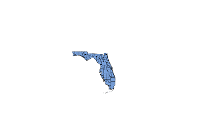

In [105]:
covid_daily_zip_file = "publish/covid_impact_poly{}.zip".format(yearDate)
covid_daily_content = AGOLConnection.content.get('2214f2f45aa24cd5bb4ff0175fcf8a2c')
covid_daily_content

In [106]:
covid_daily_collection = FeatureLayerCollection.fromitem(covid_daily_content)
response_covid = covid_daily_collection.manager.overwrite(covid_daily_zip_file)
print(response_covid)

{'success': True}


In [107]:
print(str(datetime.now()) + " Done with 1_COVID_Daily_Cases_Process")

2020-11-16 16:43:15.691614 Done with 1_COVID_Daily_Cases_Process
